In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import csv
import numpy as np

In [2]:
model_data = pd.read_parquet('../data/processed/api_processed/sample_10.parquet')
model_data = model_data.dropna()

In [3]:
# When inserting variables into the model it starts crying if the name is not a single string
model_data = model_data.rename(columns={'Total duration (m)': 'real_duration', 'Type of day': 'type_of_day', 'Bike model': 'bike_model'})

In [4]:
# Get rid of weird values
model_data = model_data[model_data['real_duration'] > 0]

In [5]:
model_data['cycling_delta_pct'] = (model_data['real_duration'] - model_data['cycling']) / model_data['real_duration']
def is_cyclist_efficient(cycling_efficiency):
    """
    This classifies cyclists by efficient/not_efficient
    -> I'm assuming that efficient cyclists (people who are taking the fastest route) travel close to the theoretical duration (predicted by TFL API)
    """
    if cycling_efficiency < 0.1:
        return 1
    else:
        return 0
    
model_data['cyclist_class'] = model_data['cycling_delta_pct'].apply(is_cyclist_efficient)
model_data['cyclist_class'].value_counts()

cyclist_class
1    42854
0    39626
Name: count, dtype: int64

In [6]:
def class_time_of_day(times):
    """
    input: HHMM
    I do not need the minutes to classify, so I'm grabbing first 2 string values
    returns: HH
    """
    times_reformatted = int(times[:2])
    if 6 < times_reformatted < 10:
        return 'morning'
    elif times_reformatted < 16:
        return 'midday'
    elif times_reformatted < 20:
        return 'evening'
    else:
        return 'night'

model_data['time_class'] = model_data['Start time'].apply(class_time_of_day)
model_data['time_class'].value_counts()

time_class
evening    27792
midday     27211
morning    17890
night       9587
Name: count, dtype: int64

In [7]:
def distance_journey(duration):
    """
    Classify by distance
    """
    if duration < 5:
        return 'short_distance'
    elif duration < 15:
        return 'medium_distance'
    else:
        return 'long_distance'

model_data['distance_class'] = model_data['real_duration'].apply(distance_journey)
model_data['distance_class'].value_counts()

distance_class
medium_distance    38388
long_distance      34993
short_distance      9099
Name: count, dtype: int64

In [8]:
model_data['cycling_public_delta_pct'] = (model_data['cycling'] - model_data['public_transport']) / model_data['cycling']
model_data['cycling_public_delta_pct'] = model_data['cycling_public_delta_pct'].replace([np.inf, -np.inf], np.nan)
model_data['cycling_public_delta_pct'].describe()

count    82352.000000
mean        -1.458475
std          0.995359
min        -10.500000
25%         -2.000000
50%         -1.250000
75%         -0.750000
max          1.000000
Name: cycling_public_delta_pct, dtype: float64

In [9]:
formula_string = "cyclist_class ~ cycling_public_delta_pct + C(type_of_day, Treatment(reference='workday')) + C(time_class, Treatment(reference='morning')) + C(season, Treatment(reference='summer')) + C(distance_class, Treatment(reference='medium_distance')) + C(bike_model)"
model = sm.formula.logit(formula=formula_string, data=model_data)
model_fitted = model.fit()

model_fitted.summary()

Optimization terminated successfully.
         Current function value: 0.532462
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          cyclist_class   No. Observations:                82352
Model:                          Logit   Df Residuals:                    82342
Method:                           MLE   Df Model:                            9
Date:                Mon, 09 Jun 2025   Pseudo R-squ.:                  0.2309
Time:                        15:40:17   Log-Likelihood:                -43849.
converged:                       True   LL-Null:                       -57014.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================================================================================
                                                                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                       3.0227      0.032     95.236      0.000       2.960       3.085
C(type_of_day, Treatment(reference='workday'))[T.weekend]                      -0.5286      0.022    -24.183      0.000      -0.571      -0.486
C(time_class, Treatment(reference='morning'))[T.evening]                       -0.5326      0.023    -23.482      0.000      -0.577      -0.488
C(time_class, Treatment(reference='morning'))[T.midday]                        -0.6455      0.023    -27.575      0.000      -0.691      -0.600
C(time_class, Treatment(reference='morning'))[T.night]                         -0.7684      0.030    -25.431      0.000      -0.828      -0.709
C(season, Treatment(reference='summer'))[T.winter]                              0.3199      0.017     18.983      0.000       0.287       0.353
C(distance_class, Treatment(reference='medium_distance'))[T.long_distance]     -1.7961      0.021    -86.414      0.000      -1.837      -1.755
C(distance_class, Treatment(reference='medium_distance'))[T.short_distance]     2.8999      0.039     74.054      0.000       2.823       2.977
C(bike_model)[T.PBSC_EBIKE]                                                     1.0290      0.025     41.942      0.000       0.981       1.077
cycling_public_delta_pct                                                        1.5072      0.014    105.522      0.000       1.479       1.535
===============================================================================================================================================
"""

### I'll calculate odds ratios to display variables better

I'll credit this guide: https://heds.nz/posts/logistic-regression-python/

In [10]:
# This piece of code transforms odd ratios from percentages to times
# Example: people travelling in the winter are OR(column) times more likely to be efficient than in the summer
# I also added a 95% confidance interval
conf = model_fitted.conf_int()
conf['OR'] = model_fitted.params
conf.columns = ["Lower CI", "Upper CI", "OR"]
np.exp(conf)

,Lower CI,Upper CI,OR
Intercept,19.307057,21.864932,20.546228
"C(type_of_day, Treatment(reference='workday'))[T.weekend]",0.564737,0.615255,0.589455
"C(time_class, Treatment(reference='morning'))[T.evening]",0.561578,0.613790,0.587104
"C(time_class, Treatment(reference='morning'))[T.midday]",0.500876,0.549013,0.524392
"C(time_class, Treatment(reference='morning'))[T.night]",0.437106,0.492065,0.463772
"C(season, Treatment(reference='summer'))[T.winter]",1.332287,1.423276,1.377030
"C(distance_class, Treatment(reference='medium_distance'))[T.long_distance]",0.159320,0.172844,0.165944
"C(distance_class, Treatment(reference='medium_distance'))[T.short_distance]",16.830372,19.622717,18.172992
C(bike_model)[T.PBSC_EBIKE],2.666843,2.936050,2.798211
cycling_public_delta_pct,4.389387,4.642155,4.514002


In [11]:
resids = model_fitted.resid_pearson

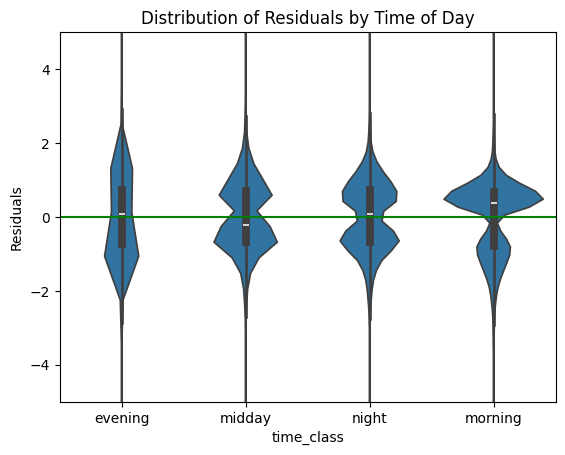

In [12]:
sns.violinplot(x='time_class', y=resids, data=model_data)
plt.ylabel('Residuals')
plt.ylim(-5,5)
plt.axhline(y=0, color='g', linestyle='-')
plt.title('Distribution of Residuals by Time of Day')
plt.show()

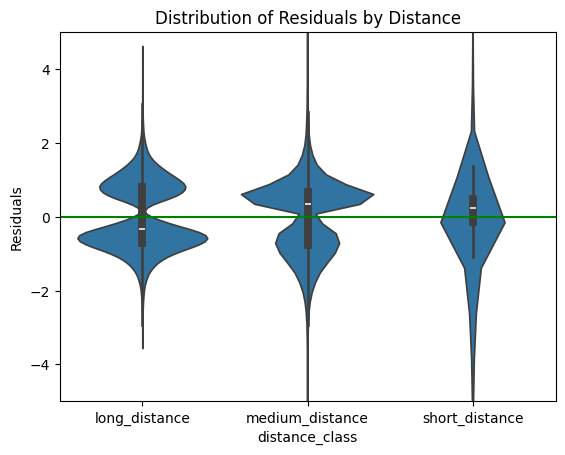

In [13]:
sns.violinplot(x='distance_class', y=resids, data=model_data)
plt.ylabel('Residuals')
plt.ylim(-5,5)
plt.axhline(y=0, color='g', linestyle='-')
plt.title('Distribution of Residuals by Distance')
plt.show()

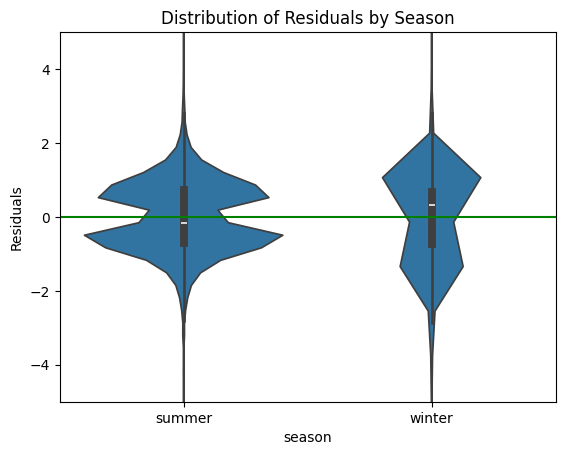

In [14]:
sns.violinplot(x='season', y=resids, data=model_data)
plt.ylabel('Residuals')
plt.ylim(-5,5)
plt.axhline(y=0, color='g', linestyle='-')
plt.title('Distribution of Residuals by Season')
plt.show()

### Testing the model
I'll link this guide: https://www.geeksforgeeks.org/logistic-regression-using-statsmodels/

In [15]:
model_data['predict_efficiency_prob'] = model_fitted.predict(model_data)
model_data['predict_class'] = (model_data['predict_efficiency_prob'] > 0.5).astype(int)
model_data['predict_class'].value_counts()

predict_class
1    44245
0    38235
Name: count, dtype: int64

In [16]:
# It shows how many predictions are correct per each class [0, 1]
print(f'Test accuracy = {accuracy_score(model_data['cyclist_class'], model_data['predict_class'])}')

Test accuracy = 0.7280916585838991


In [17]:
# Dropping irrelevant columns outside the project, saving for the data-sharing purposes
data_save = model_data.drop(['Start station number', 'End station number', 'predict_efficiency_prob', 'predict_class', 'New Start date'], axis=1)

# Uncomment if you want it saved, use whateever format you want
# data_save.to_csv('../data/result/data.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)
# data_save.to_parquet('../data/result/data.parquet', index=False)